# Introgression Trajectories
Using the sample x bin matrices, plot introgression trajectories over time. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from plotnine import *
import sys
sys.path.append("../src/")
from src import legend_kwargs

metadata = pd.read_csv("../processed-data/metadata_combined.csv.gz", index_col=0)
# I failed to remove flagged allentoft samples when saving the medatata, so this is necessary to get rid of those
# TODO: Rework the metadata script to remove flag samples
# TODO: Might also need to make sure that the metadata I save has the same sample names that I use in the samplebybins
metadata_allentoft = pd.read_csv("../processed-data/metadata_allentoft_et_al_2024.csv", index_col=0)
flag_samples = metadata_allentoft.loc[metadata_allentoft["Flag"] != "0"].index
metadata.drop(flag_samples, inplace=True)
metadata.head()

,Latitude,Longitude,Data source,Age average,Sex
Individual ID,,,,,
baa01,-29.54,31.22,Schlebusch_Science_2017,1909.0,male
bab01,-29.54,31.22,Schlebusch_Science_2017,2041.0,male
I9133,-31.98,18.52,Skoglund_Cell_2017,1970.0,male
I9134,-32.81,17.95,Skoglund_Cell_2017,1199.0,female
ela01,-28.92,29.13,Schlebusch_Science_2017,493.0,female


In [55]:
# metadata_leo = pd.read_csv("../processed-data/iasi_metadata.csv",)
# metadata_leo[["Sample Name in origina publication", "Sample name this study"]]
# [i for i in metadata_leo["Sample Name in origina publication"].unique() if "." in i]
# print(f"Samples not in index: {len([i for i in samplebybin.index if i not in metadata.index])}")
# print(f"Samples not in index: {len([i for i in samplebybin.index.str.replace('.', '-') if i not in metadata.index])}")

Samples not in index: 275
Samples not in index: 0


[]

## Make a function to plot ancestry at loci by age bins
`TODO`: Probably would be better to make barplots

In [4]:
regions = pd.read_csv("../processed-data/racimo_adaptive_regions.txt", sep="\t")
chrom = 1

In [3]:
samplebybin = pd.read_csv(f"../processed-data/sample_by_bin/chr{chrom}.csv.gz", index_col=0)
# Need to manually rename modern samples :(
samplebybin.index = samplebybin.index.str.replace('.', '-')
print(f"Samples not in index: {len([i for i in samplebybin.index.str.replace('.', '-') if i not in metadata.index])}")
samplebybin.head()

Samples not in index: 0


,0.0,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,...,283.41,283.415,283.42,283.425,283.43,283.435,283.44,283.445,283.45,283.455
UstIshim,0.000120,0.000104,0.000084,0.000059,0.000031,0.0,0.0,0.000001,0.0,0.000000,...,0.000244,0.000224,0.000199,0.000168,0.000132,0.000092,0.000046,0.000071,0.000172,0.000270
Kostenki,0.000272,0.000259,0.000225,0.000170,0.000094,0.0,0.0,0.000003,0.0,0.000000,...,0.000270,0.000295,0.000295,0.000270,0.000221,0.000148,0.000052,0.000109,0.000337,0.000547
SII,0.000302,0.000306,0.000278,0.000217,0.000124,0.0,0.0,0.000004,0.0,0.000000,...,0.000383,0.000419,0.000419,0.000382,0.000310,0.000202,0.000060,0.000122,0.000378,0.000605
SIII,0.000344,0.000349,0.000316,0.000246,0.000140,0.0,0.0,0.000005,0.0,0.000000,...,0.000422,0.000459,0.000458,0.000417,0.000339,0.000222,0.000067,0.000137,0.000424,0.000677
SIV,0.000359,0.000362,0.000328,0.000256,0.000147,0.0,0.0,0.000005,0.0,0.000001,...,0.000432,0.000472,0.000471,0.000430,0.000349,0.000230,0.000070,0.000144,0.000444,0.000708


In [44]:
bin_width = 2000
metadata["Bin"] = metadata["Age average"] // bin_width
unique_bins = sorted(metadata["Bin"].unique().tolist())[::-1]
bin_means, bin_n_samples = [], []
for b in unique_bins:
    bin_means.append(
        samplebybin.loc[
            metadata[metadata["Bin"] == b].index
        ].mean()
    )
    bin_n_samples.append(
        len(metadata[metadata["Bin"] == b].index)
    )
# Put results into df
binned = pd.DataFrame(bin_means)
binned.index = unique_bins

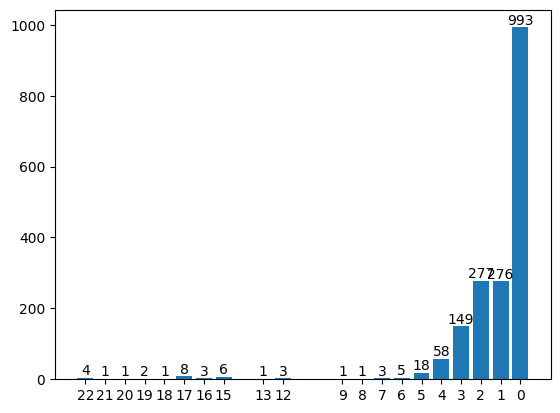

In [49]:
fig, ax = plt.subplots()
p = ax.bar(unique_bins, bin_n_samples)
ax.invert_xaxis()
ax.set_xticks(unique_bins)
ax.bar_label(p)

ax.set_title("")
ax.set_xlabel("Sample bin")

plt.show()

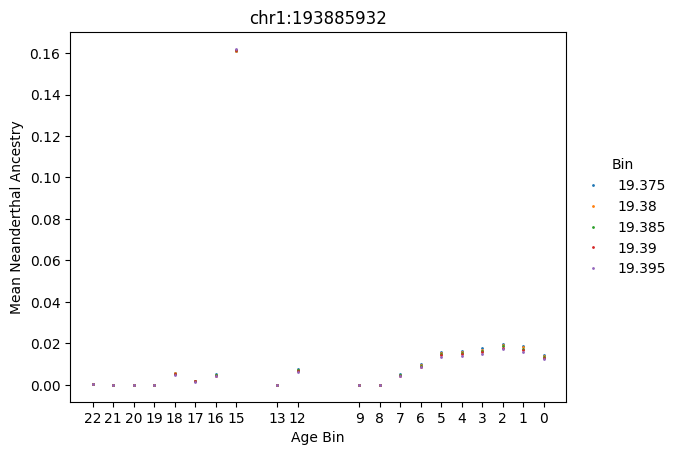

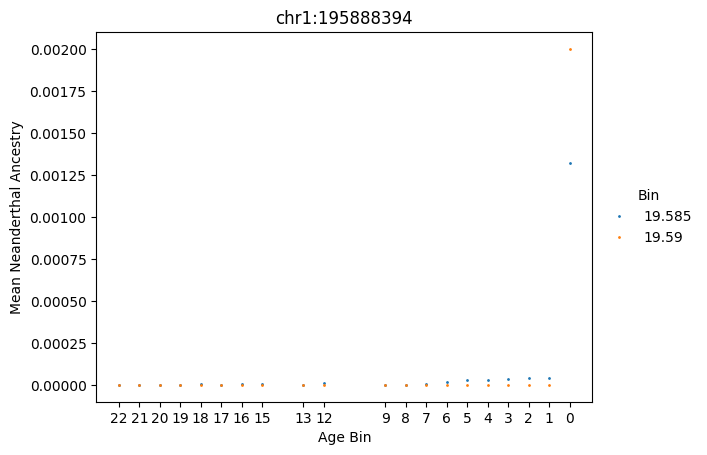

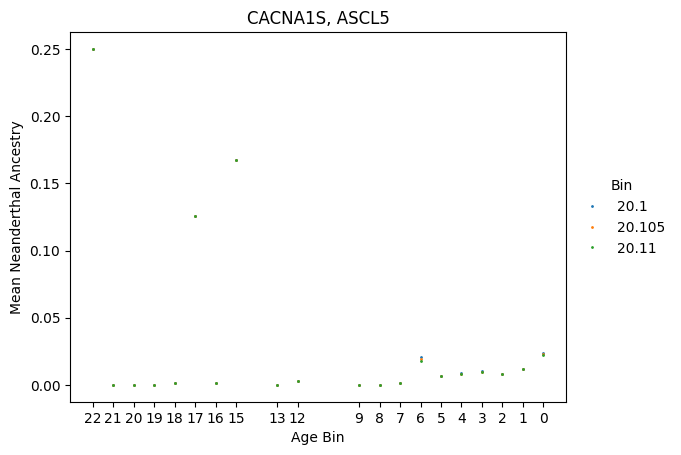

In [31]:
# Given the start and end positions of an ROI, find the bins in the samplebybin containing that ROI
import matplotlib.ticker as mtick

for _, row in regions[regions["chrom"] == chrom].iterrows():
    start, end = row['start'], row['stop']
    get_bidx = lambda x: x / 1e6 // .05
    binmin, binmax = get_bidx(start), get_bidx(end)
    roi_bidx = np.arange(binmin, binmax + 1)

    fig, ax = plt.subplots()
    binned.iloc[:, roi_bidx].plot(style="o", markersize=1, ax=ax)
    ax.invert_xaxis()
    ax.set_ylabel("Mean Neanderthal Ancestry")
    ax.set_xlabel("Age Bin")
    ax.set_title(row["genes"] if not pd.isna(row['genes']) else row['plot label'])
    ax.set_xticks(unique_bins)
    # ax.set_yscale("log")
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.legend(title="Bin", **legend_kwargs())
    plt.show()

## Make boxplots instead

<Axes: >

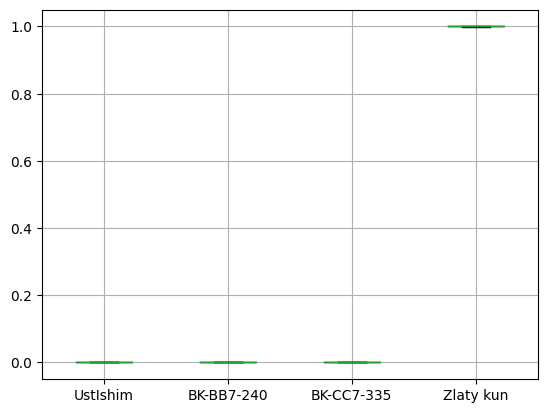

In [42]:
bin_width = 2000
metadata["Bin"] = metadata["Age average"] // bin_width
unique_bins = sorted(metadata["Bin"].unique().tolist())[::-1]
bin_means = []
for b in unique_bins:
    bin_means.append(
        samplebybin.loc[
            metadata[metadata["Bin"] == b].index
        ]
    )
# Put results into df
bin_means[0].iloc[:, roi_bidx].T.boxplot()